### Credit department in a bank is a leading data science adopter. Acquiring new credit card users is always a key priority for the bank. Giving credit cards without due diligence or assessment for creditworthiness is a huge risk.  

#### In the analysis, we will use the AdaBoost method and some other algorithms for predicting credit card approval decisions. The defining target variable, data preparation, exploratory data analysis (EDA), Model Building, Fine Tuning Parameters, and Validating Model are some of the key steps followed for developing Credit Card Approval Model.

#### The data is sourced into two files. One, the application data, and the second one monthly credit card account status information.

#### The application data will be used for feature creation. And the status (credit payment status) will be required for defining the labels - which of the applications have paid back dues and which of these turn out to bad accounts.

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
import math
import warnings
import pylab as pl
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [151]:
dw = root_dir + 'Projects/Credit Default Prediction/POC/'

## Application record EDA 

In [299]:
application_record = pd.read_csv(dw+'application_record.csv')
application_record.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [153]:
application_record.shape

(438557, 18)

In [154]:
application_record.isnull().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64

In [155]:
#Check for duplicate records
application_record[application_record.duplicated()]

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS


In [156]:
#Gender proportion in applicants
gender_val = application_record.CODE_GENDER.value_counts(normalize = True)
gender_val

F    0.671384
M    0.328616
Name: CODE_GENDER, dtype: float64

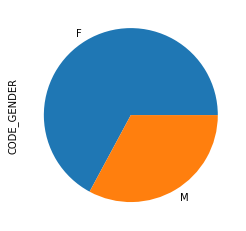

In [157]:
gender_val.plot.pie()
plt.show()

Around 67.14% of the applicants are female

In [158]:
housing_val = application_record.NAME_HOUSING_TYPE.value_counts(normalize = True)
housing_val

House / apartment      0.898016
With parents           0.043499
Municipal apartment    0.032411
Rented apartment       0.013622
Office apartment       0.008943
Co-op apartment        0.003509
Name: NAME_HOUSING_TYPE, dtype: float64

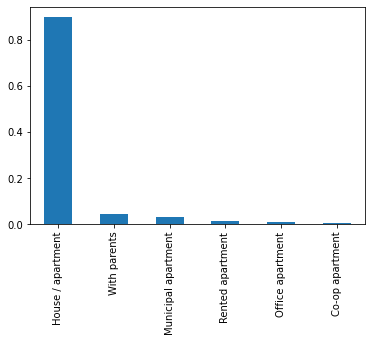

In [159]:
housing_val.plot.bar()
plt.show()

In [160]:
#House Ownership percentage
housing_ownership_count = application_record.groupby(['CODE_GENDER','NAME_HOUSING_TYPE']).agg({'ID': 'count'})
housing_ownership_count

ID
CODE_GENDER NAME_HOUSING_TYPE          
F           Co-op apartment         862
            House / apartment    267607
            Municipal apartment   10019
            Office apartment       2122
            Rented apartment       3284
            With parents          10546
M           Co-op apartment         677
            House / apartment    126224
            Municipal apartment    4195
            Office apartment       1800
            Rented apartment       2690
            With parents           8531

In [161]:
housing_ownership_percent = housing_ownership_count.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
housing_ownership_percent

ID
CODE_GENDER NAME_HOUSING_TYPE             
F           Co-op apartment       0.292759
            House / apartment    90.886768
            Municipal apartment   3.402731
            Office apartment      0.720690
            Rented apartment      1.115338
            With parents          3.581714
M           Co-op apartment       0.469757
            House / apartment    87.584393
            Municipal apartment   2.910829
            Office apartment      1.248985
            Rented apartment      1.866539
            With parents          5.919496

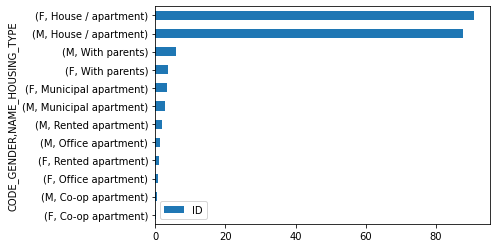

In [162]:
housing_ownership_percent.sort_values(by = 'ID').plot.barh()
plt.show()

Housing ownership percentage for females is 90.89% while for males it is 87.58%. Females applicants have higher house ownership percentage.

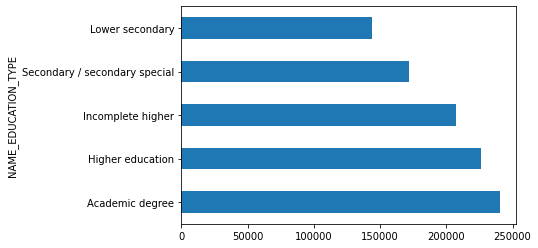

In [163]:
#Education level and income relation
application_record.groupby(["NAME_EDUCATION_TYPE"]).AMT_INCOME_TOTAL.mean().sort_values(ascending=False).plot.barh()
plt.show()

The average income increases with the education level.

## Credit record EDA 

In [164]:
credit_record = pd.read_csv(dw+"credit_record.csv")
credit_record.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [165]:
credit_record.shape

(1048575, 3)

In [166]:
credit_record.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [167]:
credit_record.describe()

,ID,MONTHS_BALANCE
count,1.048575e+06,1.048575e+06
mean,5.068286e+06,-1.913700e+01
std,4.615058e+04,1.402350e+01
min,5.001711e+06,-6.000000e+01
25%,5.023644e+06,-2.900000e+01
50%,5.062104e+06,-1.700000e+01
75%,5.113856e+06,-7.000000e+00
max,5.150487e+06,0.000000e+00


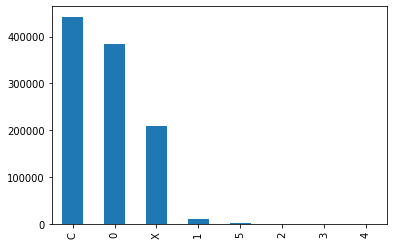

In [168]:
credit_record.STATUS.value_counts().plot.bar()
plt.show()

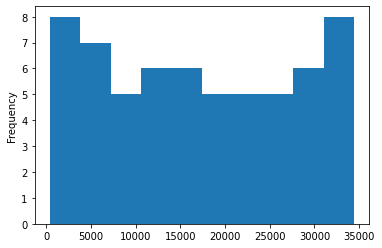

In [169]:
credit_record.MONTHS_BALANCE.value_counts().plot.hist()
plt.show()

In [170]:
#Find out for how long each customer has had a card
credit_record['MONTHS_BALANCE'] = credit_record.MONTHS_BALANCE.apply(lambda x : x*(-1))
cardholder_tenure = pd.DataFrame(credit_record.groupby('ID').agg({'MONTHS_BALANCE' : max}))
cardholder_tenure.rename(columns = {'MONTHS_BALANCE':'CUST_FOR_MONTHS'},inplace = True)
cardholder_tenure.head()

,CUST_FOR_MONTHS
ID,
5001711,3
5001712,18
5001713,21
5001714,14
5001715,59


In [171]:
#Merging application_records & credit_record to get the number of months for which the customer has had a card.
cust_data = pd.merge(application_record,cardholder_tenure,on = 'ID',how = 'inner')
cust_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CUST_FOR_MONTHS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,15
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,14
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,29
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,4
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,26


In [172]:
cust_data.shape

(36457, 19)

In [173]:
credit_record['STATUS'][credit_record["STATUS"] == 'C'] = -1
credit_record['STATUS'][credit_record["STATUS"] == 'X'] = -1
credit_record.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,-1
1,5001711,1,0
2,5001711,2,0
3,5001711,3,0
4,5001712,0,-1


In [174]:
credit_record['STATUS'].value_counts()

-1    651261
0     383120
1      11090
5       1693
2        868
3        320
4        223
Name: STATUS, dtype: int64

In [175]:
credit_record['STATUS'] = credit_record.STATUS.apply(lambda x : int(x))

In [176]:
credit_record.sort_values(by = 'STATUS',ascending = False,inplace = True)
credit_record.drop_duplicates(subset = ['ID'],inplace = True)
credit_record.shape

(45985, 3)

#### Assuming that a person is consider a defaulter to bank if he has a payment withstanding for more than 60 days. So all the customers having STATUS >= 2 will be considered as defaulters or bad customers 

In [177]:
credit_record['target'] = credit_record.STATUS.apply(lambda x : 0 if x>=2 else 1)
credit_record.drop(['STATUS','MONTHS_BALANCE'],axis = 1,inplace = True)
credit_record.head()

,ID,target
372050,5042064,0
307952,5029028,0
723708,5097065,0
942335,5135344,0
832456,5117313,0


In [178]:
credit_record.target.value_counts()

1    45318
0      667
Name: target, dtype: int64

### Merging Credit & Application Data 

In [179]:
#Merge DF to get final dataframe with all the columns
cust_data = pd.merge(cust_data, credit_record, on = "ID", how = "inner")
cust_data.shape

(36457, 20)

In [180]:
cust_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CUST_FOR_MONTHS,target
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,15,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,14,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,29,1
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,4,1
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,26,1


In [181]:
cust_data.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'CUST_FOR_MONTHS',
       'target'],
      dtype='object')

In [182]:
#Drop duplicated values
cust_data.drop_duplicates(subset = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'CUST_FOR_MONTHS',
       'target'],inplace = True)
cust_data.shape

(32177, 20)

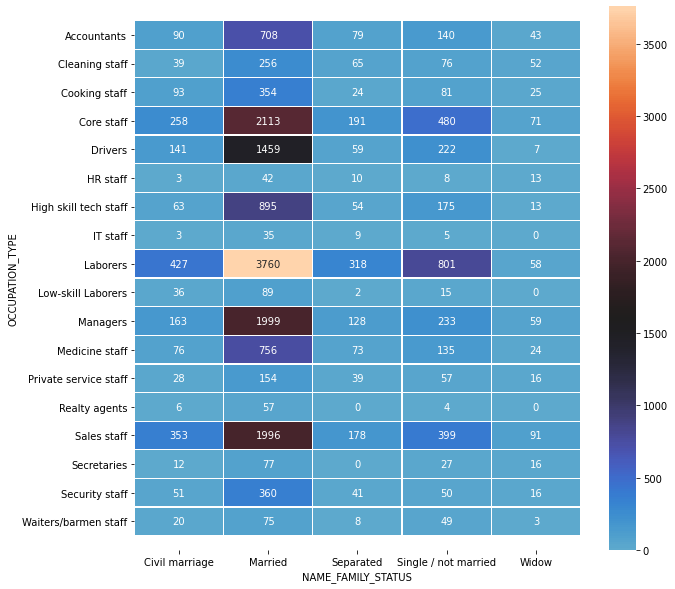

In [183]:
pvt_tbl = pd.pivot_table(data = cust_data, index = ['OCCUPATION_TYPE'], columns = ['NAME_FAMILY_STATUS'], values = 'target', aggfunc = sum,  fill_value = 0)
plt.figure(figsize=[10,10])
hm = sns.heatmap(data = pvt_tbl, annot = True, fmt='.0f', linewidths=.2, center = 1600)
bottom, top = hm.get_ylim()
hm.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

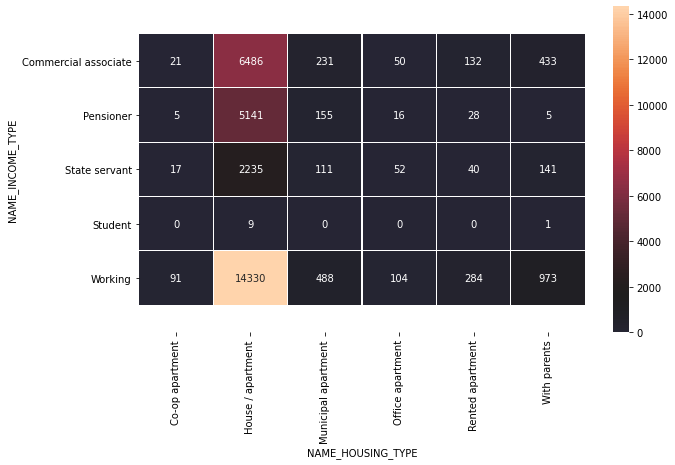

In [184]:
pvt_tbl = pd.pivot_table(data = cust_data, index = ['NAME_INCOME_TYPE'], columns = ['NAME_HOUSING_TYPE'], values = 'target', aggfunc = sum,  fill_value = 0)
plt.figure(figsize=[10,6])
hm = sns.heatmap(data = pvt_tbl, annot = True, fmt='.0f', linewidths=.2, center = 1600)
bottom, top = hm.get_ylim()
hm.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [185]:
cust_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32177 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   32177 non-null  int64  
 1   CODE_GENDER          32177 non-null  object 
 2   FLAG_OWN_CAR         32177 non-null  object 
 3   FLAG_OWN_REALTY      32177 non-null  object 
 4   CNT_CHILDREN         32177 non-null  int64  
 5   AMT_INCOME_TOTAL     32177 non-null  float64
 6   NAME_INCOME_TYPE     32177 non-null  object 
 7   NAME_EDUCATION_TYPE  32177 non-null  object 
 8   NAME_FAMILY_STATUS   32177 non-null  object 
 9   NAME_HOUSING_TYPE    32177 non-null  object 
 10  DAYS_BIRTH           32177 non-null  int64  
 11  DAYS_EMPLOYED        32177 non-null  int64  
 12  FLAG_MOBIL           32177 non-null  int64  
 13  FLAG_WORK_PHONE      32177 non-null  int64  
 14  FLAG_PHONE           32177 non-null  int64  
 15  FLAG_EMAIL           32177 non-null 

In [186]:
cust_data.isnull().sum()

ID                        0
CODE_GENDER               0
FLAG_OWN_CAR              0
FLAG_OWN_REALTY           0
CNT_CHILDREN              0
AMT_INCOME_TOTAL          0
NAME_INCOME_TYPE          0
NAME_EDUCATION_TYPE       0
NAME_FAMILY_STATUS        0
NAME_HOUSING_TYPE         0
DAYS_BIRTH                0
DAYS_EMPLOYED             0
FLAG_MOBIL                0
FLAG_WORK_PHONE           0
FLAG_PHONE                0
FLAG_EMAIL                0
OCCUPATION_TYPE        9980
CNT_FAM_MEMBERS           0
CUST_FOR_MONTHS           0
target                    0
dtype: int64

In [187]:
#Convert binary categorical columns to have integer value
cust_data['CODE_GENDER'] = cust_data.CODE_GENDER.apply(lambda x : 0 if x == 'M' else 1)
cust_data['FLAG_OWN_CAR'] = cust_data.FLAG_OWN_CAR.apply(lambda x : 0 if x == 'N' else 1)
cust_data['FLAG_OWN_REALTY'] = cust_data.FLAG_OWN_REALTY.apply(lambda x : 0 if x == 'N' else 1)
cust_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CUST_FOR_MONTHS,target
0,5008804,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,15,1
1,5008805,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,14,1
2,5008806,0,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,29,1
3,5008808,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,4,1
4,5008809,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,26,1


In [188]:
cust_data.describe()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,CUST_FOR_MONTHS,target
count,3.217700e+04,32177.000000,32177.000000,32177.000000,32177.000000,3.217700e+04,32177.000000,32177.000000,32177.0,32177.000000,32177.000000,32177.000000,32177.000000,32177.000000,32177.000000
mean,5.078181e+06,0.669267,0.378842,0.671194,0.431395,1.858457e+05,-15976.384871,59795.907387,1.0,0.225285,0.295180,0.089971,2.199521,26.070268,0.981415
std,4.181678e+04,0.470484,0.485106,0.469787,0.745757,1.007217e+05,4214.213798,138116.549593,0.0,0.417776,0.456131,0.286145,0.914533,16.465296,0.135055
min,5.008804e+06,0.000000,0.000000,0.000000,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,5.041913e+06,0.000000,0.000000,0.000000,0.000000,1.215000e+05,-19457.000000,-3141.000000,1.0,0.000000,0.000000,0.000000,2.000000,12.000000,1.000000
50%,5.074710e+06,1.000000,0.000000,1.000000,0.000000,1.575000e+05,-15565.000000,-1539.000000,1.0,0.000000,0.000000,0.000000,2.000000,24.000000,1.000000
75%,5.114631e+06,1.000000,1.000000,1.000000,1.000000,2.250000e+05,-12454.000000,-401.000000,1.0,0.000000,1.000000,0.000000,3.000000,39.000000,1.000000
max,5.150487e+06,1.000000,1.000000,1.000000,19.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,60.000000,1.000000


In [189]:
cust_data.FLAG_MOBIL.value_counts()

1    32177
Name: FLAG_MOBIL, dtype: int64

Since all the rows have FLAG_MOBIL as 1 so there is no variation available for this column and hence it will not add any value to the model. Hence it can be dropped

In [190]:
cust_data.drop('FLAG_MOBIL', axis = 1, inplace = True)
cust_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CUST_FOR_MONTHS,target
0,5008804,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,NaN,2.0,15,1
1,5008805,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,NaN,2.0,14,1
2,5008806,0,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,0,0,0,Security staff,2.0,29,1
3,5008808,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,Sales staff,1.0,4,1
4,5008809,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,Sales staff,1.0,26,1


In [191]:
#CNT_FAM_MEMBERS can not be float. Convert the column to int type
cust_data['CNT_FAM_MEMBERS'] = cust_data['CNT_FAM_MEMBERS'].astype('int')
cust_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CUST_FOR_MONTHS,target
0,5008804,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,NaN,2,15,1
1,5008805,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,NaN,2,14,1
2,5008806,0,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,0,0,0,Security staff,2,29,1
3,5008808,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,Sales staff,1,4,1
4,5008809,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,Sales staff,1,26,1


In [192]:
def box_plot(df,col) :
    sns.boxplot(data = df, y = col)
    plt.show()

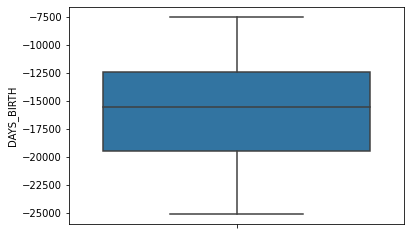

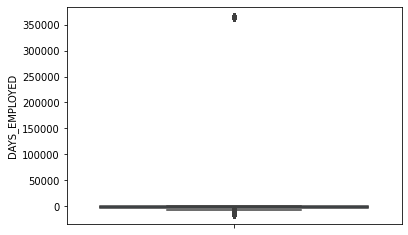

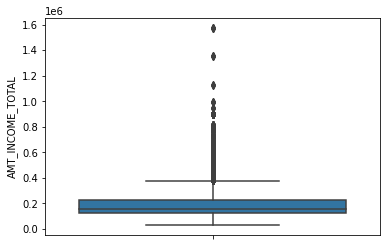

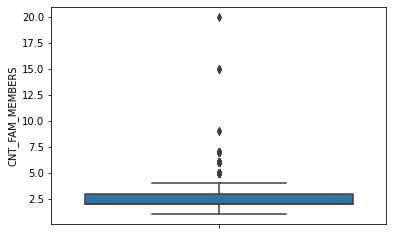

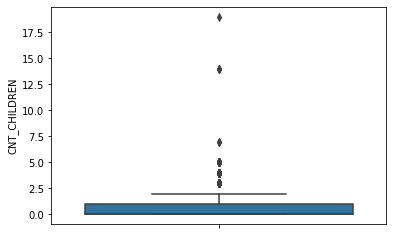

In [193]:
boxplt_col = ["DAYS_BIRTH","DAYS_EMPLOYED","AMT_INCOME_TOTAL","CNT_FAM_MEMBERS","CNT_CHILDREN"]
for col in boxplt_col :
    box_plot(cust_data,col)

In [194]:
#Checking outliers for DAYS_EMPLOYED column
cust_data[cust_data['DAYS_EMPLOYED'] > 0]

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CUST_FOR_MONTHS,target
7,5008812,1,0,1,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,0,0,0,NaN,1,20,1
8,5008813,1,0,1,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,0,0,0,NaN,1,16,1
9,5008814,1,0,1,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,0,0,0,NaN,1,17,1
69,5008884,1,0,1,0,315000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-20186,365243,0,0,0,NaN,1,40,1
150,5008974,1,0,1,0,112500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-22319,365243,0,0,0,NaN,2,49,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36408,5126278,1,0,0,0,162000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21244,365243,0,0,0,NaN,2,28,0
36418,5139446,1,0,1,0,112500.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-21256,365243,0,1,0,NaN,1,16,0
36432,5145690,1,0,1,0,306000.0,Pensioner,Higher education,Married,House / apartment,-21590,365243,0,0,0,NaN,2,17,0
36434,5145817,1,0,1,0,90000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-22011,365243,0,0,0,NaN,2,39,0


In [195]:
cust_data[cust_data['DAYS_EMPLOYED'] > 0].NAME_INCOME_TYPE.value_counts()

Pensioner    5461
Name: NAME_INCOME_TYPE, dtype: int64

In [196]:
cust_data[(cust_data['DAYS_EMPLOYED'] > 0) & (cust_data.NAME_INCOME_TYPE == 'Pensioner')].shape

(5461, 19)

All the customers with a positive 'DAYS_EMPLOYED' are pensioners and represent a valid data.

In [197]:
#Convert the Integer columns to positive integers
def convert_to_positive(df,column) :
    df[column] = df[column].apply(lambda x : x*-1)
    return df

In [198]:
continuous_variable = ['DAYS_BIRTH','DAYS_EMPLOYED']
for c in continuous_variable :
    cust_data = convert_to_positive(cust_data,c)
cust_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CUST_FOR_MONTHS,target
0,5008804,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,12005,4542,1,0,0,NaN,2,15,1
1,5008805,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,12005,4542,1,0,0,NaN,2,14,1
2,5008806,0,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,21474,1134,0,0,0,Security staff,2,29,1
3,5008808,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,19110,3051,0,1,1,Sales staff,1,4,1
4,5008809,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,19110,3051,0,1,1,Sales staff,1,26,1


In [199]:
#Convert DAYS to YEARS
cust_data['EMP_YEARS'] = cust_data.DAYS_EMPLOYED/365
cust_data['AGE'] = cust_data.DAYS_BIRTH/365
cust_data.drop(["DAYS_BIRTH","DAYS_EMPLOYED"],axis = 1,inplace = True)
cust_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CUST_FOR_MONTHS,target,EMP_YEARS,AGE
0,5008804,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,NaN,2,15,1,12.443836,32.890411
1,5008805,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,NaN,2,14,1,12.443836,32.890411
2,5008806,0,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Security staff,2,29,1,3.106849,58.832877
3,5008808,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1,4,1,8.358904,52.356164
4,5008809,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1,26,1,8.358904,52.356164


Replacing all the EMP_YEARS for all pensioners to be -1.

In [200]:
cust_data['EMP_YEARS'] = cust_data.EMP_YEARS.apply(lambda x : -1 if x<0 else x)

In [201]:
def bad_cust_proportion(col) :
    bad_prop_cnt = cust_data.groupby([col,'target']).agg({'ID': 'count'})
    bad_prop_percent = bad_prop_cnt.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))
    return bad_prop_percent

In [202]:
bad_cust_proportion('FLAG_OWN_CAR')

ID
FLAG_OWN_CAR target           
0            0        1.926252
             1       98.073748
1            0        1.747334
             1       98.252666

Proportion of bad customers for people who own a car is less than those who don't own a car

In [203]:
bad_cust_proportion('NAME_HOUSING_TYPE')

ID
NAME_HOUSING_TYPE   target           
Co-op apartment     0        2.189781
                    1       97.810219
House / apartment   0        1.817359
                    1       98.182641
Municipal apartment 0        2.955665
                    1       97.044335
Office apartment    0        3.896104
                    1       96.103896
Rented apartment    0        1.626016
                    1       98.373984
With parents        0        1.646612
                    1       98.353388

People living on rent don't have the highest proportion of bad customers. People having 'Office apartment' have the highest proportion of bad customers

In [204]:
bad_cust_proportion('NAME_FAMILY_STATUS')

ID
NAME_FAMILY_STATUS   target           
Civil marriage       0        1.717557
                     1       98.282443
Married              0        1.720625
                     1       98.279375
Separated            0        1.615509
                     1       98.384491
Single / not married 0        2.327221
                     1       97.672779
Widow                0        3.232917
                     1       96.767083

Single customers have a higher proportion of bad customers as compared to married customers

In [205]:
cust_data['OCCUPATION_TYPE'] = cust_data.OCCUPATION_TYPE.apply(lambda x : 'UNEMPLOYED' if pd.isnull(x) else x)
cust_data.OCCUPATION_TYPE.value_counts()

UNEMPLOYED               9980
Laborers                 5460
Core staff               3185
Sales staff              3062
Managers                 2629
Drivers                  1931
High skill tech staff    1229
Accountants              1082
Medicine staff           1074
Cooking staff             586
Security staff            530
Cleaning staff            493
Private service staff     296
Waiters/barmen staff      157
Low-skill Laborers        150
Secretaries               134
HR staff                   77
Realty agents              67
IT staff                   55
Name: OCCUPATION_TYPE, dtype: int64

## Calculating WOE & IV  
Weight of Evidence (WoE) is a measure of the “strength” of a grouping technique to separate good and bad. This method was developed primarily to build a predictive model to evaluate the risk of loan default in the credit and financial industry.  

Information Value (IV) measures the importance of a feature and depends only on frequency counting and does not need to fit a model to obtain an attribute importance score

In [206]:
def calc_woe_iv(col) :
    df = pd.DataFrame(columns = ['values','total','good','bad','event_rate','non_event_rate','per_total_events','per_total_non_events','WOE','IV'])
    df['values'] = cust_data[col].unique()
    df.set_index('values',inplace = True)
    
    values = cust_data[col].unique()
    total_dict = dict(cust_data.groupby(col).size())
    col_target_dict = dict(cust_data.groupby([col,'target']).size())
    target_count = dict(cust_data.groupby(['target']).size())
    
    for value in values :
        df.loc[value]['total'] = total_dict[value]
        if (value,1) in col_target_dict:
            df.loc[value]['good'] = col_target_dict[(value,1)]
        else :
            df.loc[value]['good'] = 0
        
        if (value,0) in col_target_dict:
            df.loc[value]['bad'] = col_target_dict[(value,0)]
        else :
            df.loc[value]['bad'] = 0
            
        if df.loc[value]['bad'] == 0 :
            df = df.drop([value])
        
    df['event_rate'] = df['good']/df['total']
    df['non_event_rate'] = df['bad']/df['total']
    
    df['per_total_events'] = df['good']/target_count[1]
    df['per_total_non_events'] = df['bad']/target_count[0]
    
    df['WOE'] = np.log(df.per_total_events.astype('float64')/df.per_total_non_events.astype('float64'))
    df['IV'] = (df['per_total_events'] - df['per_total_non_events']) * df['WOE']
    
    return df    

In [207]:
iv_values = pd.DataFrame(columns = ['col_name','iv_value'])

In [208]:
iv_values['col_name'] = cust_data.columns
iv_values.set_index(['col_name'],inplace = True)
iv_values.drop(['ID','target'],inplace = True)
iv_values

,iv_value
col_name,
CODE_GENDER,NaN
FLAG_OWN_CAR,NaN
FLAG_OWN_REALTY,NaN
CNT_CHILDREN,NaN
AMT_INCOME_TOTAL,NaN
NAME_INCOME_TYPE,NaN
NAME_EDUCATION_TYPE,NaN
NAME_FAMILY_STATUS,NaN
NAME_HOUSING_TYPE,NaN


### 1. Binary Variable 

#### a. CODE_GENDER

In [209]:
CODE_GENDER_df = calc_woe_iv('CODE_GENDER')
iv_values.loc['CODE_GENDER'] = CODE_GENDER_df.IV.sum()
print(iv_values.loc['CODE_GENDER'])
CODE_GENDER_df

iv_value    0.0115884
Name: CODE_GENDER, dtype: object


,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
0,10642,10414,228,0.978575,0.0214245,0.329776,0.381271,-0.145096,0.0074717
1,21535,21165,370,0.982819,0.0171813,0.670224,0.618729,0.079944,0.00411671


In [210]:
cust_data['CODE_GENDER'].value_counts()
cust_data.groupby(['CODE_GENDER','target']).size()
print(10414/10642,228/10642)
print(cust_data.target.value_counts())
print(10414/31579, 21165/31579)
np.log((10414/31579)/(228/598))

0.978575455741402 0.021424544258598008
1    31579
0      598
Name: target, dtype: int64
0.3297761170398049 0.6702238829601951


-0.14509616297808547

#### b.FLAG_OWN_CAR

In [211]:
FLAG_OWN_CAR_df = calc_woe_iv('FLAG_OWN_CAR')
iv_values.loc['FLAG_OWN_CAR'] = FLAG_OWN_CAR_df.IV.sum()
print(iv_values.loc['FLAG_OWN_CAR'])
FLAG_OWN_CAR_df

iv_value    0.00229239
Name: FLAG_OWN_CAR, dtype: object


,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
1,12190,11977,213,0.982527,0.0174733,0.379271,0.356187,0.062794,0.00144953
0,19987,19602,385,0.980737,0.0192625,0.620729,0.643813,-0.036513,0.000842864


#### c. FLAG_OWN_REALTY

In [212]:
FLAG_OWN_REALTY_df = calc_woe_iv('FLAG_OWN_REALTY')
iv_values.loc['FLAG_OWN_REALTY'] = FLAG_OWN_REALTY_df.IV.sum()
print(iv_values.loc['FLAG_OWN_REALTY'])
FLAG_OWN_REALTY_df

iv_value    0.0304867
Name: FLAG_OWN_REALTY, dtype: object


,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
1,21597,21245,352,0.983701,0.0162986,0.672757,0.588629,0.133589,0.0112386
0,10580,10334,246,0.976749,0.0232514,0.327243,0.411371,-0.228794,0.0192481


#### d. FLAG_WORK_PHONE

In [213]:
FLAG_WORK_PHONE_df = calc_woe_iv('FLAG_WORK_PHONE')
iv_values.loc['FLAG_WORK_PHONE'] = FLAG_WORK_PHONE_df.IV.sum()
print(iv_values.loc['FLAG_WORK_PHONE'])
FLAG_WORK_PHONE_df

iv_value    0.00205838
Name: FLAG_WORK_PHONE, dtype: object


,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
1,7249,7103,146,0.979859,0.0201407,0.224928,0.244147,-0.081991,0.0015758
0,24928,24476,452,0.981868,0.0181322,0.775072,0.755853,0.025109,0.00048258


#### e. FLAG_PHONE

In [214]:
FLAG_PHONE_df = calc_woe_iv('FLAG_PHONE')
iv_values.loc['FLAG_PHONE'] = FLAG_PHONE_df.IV.sum()
print(iv_values.loc['FLAG_PHONE'])
FLAG_PHONE_df

iv_value    0.000168305
Name: FLAG_PHONE, dtype: object


,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
0,22679,22261,418,0.981569,0.0184311,0.70493,0.698997,0.008453,5.01602e-05
1,9498,9318,180,0.981049,0.0189514,0.29507,0.301003,-0.019910,0.000118145


#### f. FLAG_EMAIL

In [215]:
FLAG_EMAIL_df = calc_woe_iv('FLAG_EMAIL')
iv_values.loc['FLAG_EMAIL'] = FLAG_EMAIL_df.IV.sum()
print(iv_values.loc['FLAG_EMAIL'])
FLAG_EMAIL_df

iv_value    0.000529595
Name: FLAG_EMAIL, dtype: object


,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
0,29282,28734,548,0.981285,0.0187146,0.909908,0.916388,-0.007096,4.5977e-05
1,2895,2845,50,0.982729,0.0172712,0.0900915,0.083612,0.074638,0.000483618


### 2. Categorical Variables 

#### a. NAME_INCOME_TYPE 

In [216]:
NAME_INCOME_TYPE_df = calc_woe_iv('NAME_INCOME_TYPE')
iv_values.loc['NAME_INCOME_TYPE'] = NAME_INCOME_TYPE_df.IV.sum()
print(iv_values.loc['NAME_INCOME_TYPE'])
NAME_INCOME_TYPE_df

iv_value    0.0173191
Name: NAME_INCOME_TYPE, dtype: object


,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
Working,16564,16270,294,0.982251,0.0177493,0.515216,0.491639,0.046842,0.00110438
Commercial associate,7492,7353,139,0.981447,0.0185531,0.232845,0.232441,0.001733,6.9859e-07
Pensioner,5478,5350,128,0.976634,0.0233662,0.169416,0.214047,-0.233835,0.0104362
State servant,2633,2596,37,0.985948,0.0140524,0.0822065,0.0618729,0.284152,0.00577784


#### b. NAME_EDUCATION_TYPE

In [217]:
NAME_EDUCATION_TYPE_df = calc_woe_iv('NAME_EDUCATION_TYPE')
iv_values.loc['NAME_EDUCATION_TYPE'] = NAME_EDUCATION_TYPE_df.IV.sum()
print(iv_values.loc['NAME_EDUCATION_TYPE'])
NAME_EDUCATION_TYPE_df

iv_value    0.00858051
Name: NAME_EDUCATION_TYPE, dtype: object


,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
Higher education,8670,8503,167,0.980738,0.0192618,0.269261,0.279264,-0.036476,0.000364873
Secondary / secondary special,21895,21505,390,0.982188,0.0178123,0.680991,0.652174,0.043237,0.00124595
Incomplete higher,1251,1220,31,0.97522,0.0247802,0.0386333,0.0518395,-0.294038,0.00388312
Lower secondary,336,326,10,0.970238,0.0297619,0.0103233,0.0167224,-0.482345,0.00308657


#### c. NAME_FAMILY_STATUS

In [218]:
NAME_FAMILY_STATUS_df = calc_woe_iv('NAME_FAMILY_STATUS')
iv_values.loc['NAME_FAMILY_STATUS'] = NAME_FAMILY_STATUS_df.IV.sum()
print(iv_values.loc['NAME_FAMILY_STATUS'])
NAME_FAMILY_STATUS_df

iv_value    0.0315722
Name: NAME_FAMILY_STATUS, dtype: object


,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
Civil marriage,2620,2575,45,0.982824,0.0171756,0.0815415,0.0752508,0.080285,0.000505051
Married,22085,21705,380,0.982794,0.0172062,0.687324,0.635452,0.078470,0.00407041
Single / not married,4254,4155,99,0.976728,0.0232722,0.131575,0.165552,-0.229709,0.00780484
Separated,1857,1827,30,0.983845,0.0161551,0.0578549,0.0501672,0.142576,0.00109608
Widow,1361,1317,44,0.967671,0.0323292,0.0417049,0.0735786,-0.567735,0.0180958


#### d. NAME_HOUSING_TYPE

In [219]:
NAME_HOUSING_TYPE_df = calc_woe_iv('NAME_HOUSING_TYPE')
iv_values.loc['NAME_HOUSING_TYPE'] = NAME_HOUSING_TYPE_df.IV.sum()
print(iv_values.loc['NAME_HOUSING_TYPE'])
NAME_HOUSING_TYPE_df

iv_value    0.0166776
Name: NAME_HOUSING_TYPE, dtype: object


,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
Rented apartment,492,484,8,0.98374,0.0162602,0.0153266,0.0133779,0.135986,0.000264999
House / apartment,28723,28201,522,0.981826,0.0181736,0.89303,0.87291,0.022788,0.000458511
Municipal apartment,1015,985,30,0.970443,0.0295567,0.0311916,0.0501672,-0.475213,0.00901745
With parents,1579,1553,26,0.983534,0.0164661,0.0491783,0.0434783,0.123190,0.000702184
Co-op apartment,137,134,3,0.978102,0.0218978,0.00424333,0.00501672,-0.167429,0.000129489
Office apartment,231,222,9,0.961039,0.038961,0.00702999,0.0150502,-0.761204,0.00610499


#### e. OCCUPATION_TYPE

In [220]:
OCCUPATION_TYPE_df = calc_woe_iv('OCCUPATION_TYPE')
iv_values.loc['OCCUPATION_TYPE'] = OCCUPATION_TYPE_df.IV.sum()
print(iv_values.loc['OCCUPATION_TYPE'])
OCCUPATION_TYPE_df

iv_value    0.0533465
Name: OCCUPATION_TYPE, dtype: object


,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
UNEMPLOYED,9980,9790,190,0.980962,0.0190381,0.310016,0.317726,-0.024564,0.00018938
Security staff,530,518,12,0.977358,0.0226415,0.0164033,0.0200669,-0.201588,0.000738536
Sales staff,3062,3017,45,0.985304,0.0146963,0.0955382,0.0752508,0.238699,0.00484256
Accountants,1082,1060,22,0.979667,0.0203327,0.0335666,0.0367893,-0.091675,0.00029544
Laborers,5460,5364,96,0.982418,0.0175824,0.16986,0.160535,0.056460,0.000526469
Managers,2629,2582,47,0.982122,0.0178775,0.0817632,0.0785953,0.039515,0.000125179
Drivers,1931,1888,43,0.977732,0.0222683,0.0597866,0.0719064,-0.184584,0.00223711
Core staff,3185,3113,72,0.977394,0.022606,0.0985782,0.120401,-0.199981,0.00436422
High skill tech staff,1229,1200,29,0.976404,0.0235964,0.0379999,0.048495,-0.243876,0.00255949


### 3. Continuous Variables

In [221]:
cust_data.describe()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,CUST_FOR_MONTHS,target,EMP_YEARS,AGE
count,3.217700e+04,32177.000000,32177.000000,32177.000000,32177.000000,3.217700e+04,32177.000000,32177.000000,32177.000000,32177.000000,32177.000000,32177.000000,32177.000000,32177.000000
mean,5.078181e+06,0.669267,0.378842,0.671194,0.431395,1.858457e+05,0.225285,0.295180,0.089971,2.199521,26.070268,0.981415,5.836369,43.770917
std,4.181678e+04,0.470484,0.485106,0.469787,0.745757,1.007217e+05,0.417776,0.456131,0.286145,0.914533,16.465296,0.135055,6.651120,11.545791
min,5.008804e+06,0.000000,0.000000,0.000000,0.000000,2.700000e+04,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-1.000000,20.517808
25%,5.041913e+06,0.000000,0.000000,0.000000,0.000000,1.215000e+05,0.000000,0.000000,0.000000,2.000000,12.000000,1.000000,1.098630,34.120548
50%,5.074710e+06,1.000000,0.000000,1.000000,0.000000,1.575000e+05,0.000000,0.000000,0.000000,2.000000,24.000000,1.000000,4.216438,42.643836
75%,5.114631e+06,1.000000,1.000000,1.000000,1.000000,2.250000e+05,0.000000,1.000000,0.000000,3.000000,39.000000,1.000000,8.605479,53.306849
max,5.150487e+06,1.000000,1.000000,1.000000,19.000000,1.575000e+06,1.000000,1.000000,1.000000,20.000000,60.000000,1.000000,43.049315,68.909589


#### a. CNT_CHILDREN

Since all the bins should have atleast 5% of the total observations, therefore dividing 'CNT_CHILDREN' into [0,1,1+] bins

In [222]:
cust_data['cnt_child_category'] = cust_data.CNT_CHILDREN.apply(lambda x : '1+' if x>= 2 else str(x))

In [223]:
cust_data['cnt_child_category']

0        0
1        0
2        0
3        0
4        0
        ..
36452    0
36453    0
36454    0
36455    0
36456    0
Name: cnt_child_category, Length: 32177, dtype: object

In [224]:
CNT_CHILDREN_df = calc_woe_iv('cnt_child_category')
iv_values.loc['CNT_CHILDREN'] = CNT_CHILDREN_df.IV.sum()
print(iv_values.loc['CNT_CHILDREN'])
CNT_CHILDREN_df

iv_value    0.000711572
Name: CNT_CHILDREN, dtype: object


,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
0,22233,21813,420,0.981109,0.0188908,0.690744,0.702341,-0.016650,0.000193097
1,6609,6492,117,0.982297,0.0177031,0.20558,0.195652,0.049495,0.000491362
1+,3335,3274,61,0.981709,0.0182909,0.103676,0.102007,0.016237,2.71127e-05


#### b. AMT_INCOME_TOTAL

In [225]:
bins = [0, 70000, 100000, 150000, 200000, 250000, 300000, 350000, 1600000]
labels = ['70000', '100000', '150000', '200000', '250000', '300000', '350000', '1600000']
cust_data['income_bin'] = pd.cut(cust_data['AMT_INCOME_TOTAL'], bins = bins, labels = labels)
cust_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CUST_FOR_MONTHS,target,EMP_YEARS,AGE,cnt_child_category,income_bin
0,5008804,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,UNEMPLOYED,2,15,1,12.443836,32.890411,0,1600000
1,5008805,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,UNEMPLOYED,2,14,1,12.443836,32.890411,0,1600000
2,5008806,0,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Security staff,2,29,1,3.106849,58.832877,0,150000
3,5008808,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1,4,1,8.358904,52.356164,0,300000
4,5008809,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1,26,1,8.358904,52.356164,0,300000


In [226]:
cust_data.income_bin.value_counts()

150000     9059
200000     6832
250000     6019
100000     3113
300000     2407
1600000    2028
70000      1411
350000     1308
Name: income_bin, dtype: int64

In [227]:
AMT_INCOME_TOTAL_df = calc_woe_iv('income_bin')
iv_values.loc['AMT_INCOME_TOTAL'] = AMT_INCOME_TOTAL_df.IV.sum()
print(iv_values.loc['AMT_INCOME_TOTAL'])
AMT_INCOME_TOTAL_df.sort_values(by = 'WOE',inplace = True)
AMT_INCOME_TOTAL_df

iv_value    0.0102759
Name: AMT_INCOME_TOTAL, dtype: object


,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
100000,3113,3045,68,0.978156,0.0218439,0.0964248,0.113712,-0.164908,0.00285086
350000,1308,1281,27,0.979358,0.0206422,0.0405649,0.0451505,-0.107097,0.000491103
300000,2407,2358,49,0.979643,0.0203573,0.0746699,0.0819398,-0.092908,0.000675435
250000,6019,5904,115,0.980894,0.0191062,0.18696,0.192308,-0.028204,0.000150833
150000,9059,8890,169,0.981345,0.0186555,0.281516,0.282609,-0.003873,4.23152e-06
200000,6832,6715,117,0.982875,0.0171253,0.212641,0.195652,0.083268,0.00141466
1600000,2028,1994,34,0.983235,0.0167653,0.0631432,0.0568562,0.104881,0.000659388
70000,1411,1392,19,0.986534,0.0134656,0.0440799,0.0317726,0.327401,0.00402944


#### c. CNT_FAM_MEMBERS

In [228]:
cust_data.CNT_FAM_MEMBERS.value_counts()

2     17166
1      6168
3      5665
4      2748
5       357
6        50
7        17
15        3
9         2
20        1
Name: CNT_FAM_MEMBERS, dtype: int64

In [229]:
cust_data['cnt_family_bin'] = cust_data.CNT_FAM_MEMBERS.apply(lambda x : '3+' if x>= 4 else str(x))

In [230]:
CNT_FAM_MEMBERS_df = calc_woe_iv('cnt_family_bin')
iv_values.loc['CNT_FAM_MEMBERS'] = CNT_FAM_MEMBERS_df.IV.sum()
print(iv_values.loc['CNT_FAM_MEMBERS'])
CNT_FAM_MEMBERS_df.sort_values(by = 'WOE',inplace = True)
CNT_FAM_MEMBERS_df

iv_value    0.00803882
Name: CNT_FAM_MEMBERS, dtype: object


,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
1,6168,6032,136,0.977951,0.0220493,0.191013,0.227425,-0.174478,0.00635304
3,5665,5564,101,0.982171,0.0178288,0.176193,0.168896,0.042295,0.000308616
2,17166,16861,305,0.982232,0.0177677,0.533931,0.510033,0.045790,0.00109426
3+,3178,3122,56,0.982379,0.0176211,0.0988632,0.0936455,0.054221,0.000282906


#### d. CUST_FOR_MONTHS

In [231]:
bins = [-1, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60]
labels = ['0.5','1','1.5','2','2.5','3','3.5','4','4.5','5']
cust_data['months_bin'] = pd.cut(cust_data['CUST_FOR_MONTHS'], bins = bins,labels = labels)
cust_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CUST_FOR_MONTHS,target,EMP_YEARS,AGE,cnt_child_category,income_bin,cnt_family_bin,months_bin
0,5008804,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,UNEMPLOYED,2,15,1,12.443836,32.890411,0,1600000,2,1.5
1,5008805,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,UNEMPLOYED,2,14,1,12.443836,32.890411,0,1600000,2,1.5
2,5008806,0,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Security staff,2,29,1,3.106849,58.832877,0,150000,2,2.5
3,5008808,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1,4,1,8.358904,52.356164,0,300000,1,0.5
4,5008809,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1,26,1,8.358904,52.356164,0,300000,1,2.5


In [232]:
cust_data.months_bin.value_counts()

1      4279
0.5    4200
1.5    4096
2      3639
2.5    3453
3.5    3079
3      3049
4      2433
4.5    2214
5      1735
Name: months_bin, dtype: int64

In [233]:
CUST_FOR_MONTHS_df = calc_woe_iv('months_bin')
iv_values.loc['CUST_FOR_MONTHS'] = CUST_FOR_MONTHS_df.IV.sum()
print(iv_values.loc['CUST_FOR_MONTHS'])
CUST_FOR_MONTHS_df.sort_values(by = 'WOE',inplace = True)
CUST_FOR_MONTHS_df
#The WOE should be monotonic i.e. either growing or decreasing with the bins  

iv_value    0.290192
Name: CUST_FOR_MONTHS, dtype: object


,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
5,1735,1669,66,0.96196,0.0380403,0.0528516,0.110368,-0.736332,0.0423511
3.5,3079,2990,89,0.971095,0.0289055,0.0946832,0.148829,-0.452265,0.0244884
4,2433,2364,69,0.97164,0.02836,0.0748599,0.115385,-0.432653,0.0175332
4.5,2214,2154,60,0.9729,0.0271003,0.0682099,0.100334,-0.385920,0.0123975
3,3049,2989,60,0.980321,0.0196786,0.0946515,0.100334,-0.058307,0.000331357
2.5,3453,3387,66,0.980886,0.0191138,0.107255,0.110368,-0.028612,8.90705e-05
2,3639,3584,55,0.984886,0.015114,0.113493,0.0919732,0.210245,0.00452445
1.5,4096,4037,59,0.985596,0.0144043,0.127838,0.0986622,0.259063,0.00755839
1,4279,4221,58,0.986445,0.0135546,0.133665,0.09699,0.320727,0.0117626


#### e. EMP_YEARS

In [234]:
bins = [-2, -1,  5, 10, 15,  20, 50]
labels = ['retired','5','10','15','20','20+']
cust_data['emp_years_bin'] = pd.cut(cust_data['EMP_YEARS'], bins = bins, labels = labels)
cust_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CUST_FOR_MONTHS,target,EMP_YEARS,AGE,cnt_child_category,income_bin,cnt_family_bin,months_bin,emp_years_bin
0,5008804,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,UNEMPLOYED,2,15,1,12.443836,32.890411,0,1600000,2,1.5,15
1,5008805,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,UNEMPLOYED,2,14,1,12.443836,32.890411,0,1600000,2,1.5,15
2,5008806,0,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Security staff,2,29,1,3.106849,58.832877,0,150000,2,2.5,5
3,5008808,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1,4,1,8.358904,52.356164,0,300000,1,0.5,10
4,5008809,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1,26,1,8.358904,52.356164,0,300000,1,2.5,10


In [235]:
cust_data.emp_years_bin.value_counts()

5          12599
10          7866
retired     5461
15          3271
20+         1531
20          1449
Name: emp_years_bin, dtype: int64

In [236]:
EMP_YEARS_df = calc_woe_iv('emp_years_bin')
iv_values.loc['EMP_YEARS'] = EMP_YEARS_df.IV.sum()
print(iv_values.loc['EMP_YEARS'])
EMP_YEARS_df.sort_values(by = 'WOE',inplace = True)
EMP_YEARS_df

iv_value    0.0376717
Name: EMP_YEARS, dtype: object


,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
5,12599,12324,275,0.978173,0.0218271,0.390259,0.459866,-0.164124,0.0114242
retired,5461,5350,111,0.979674,0.0203259,0.169416,0.185619,-0.091335,0.00147984
15,3271,3216,55,0.983186,0.0168144,0.10184,0.0919732,0.101904,0.00100544
10,7866,7744,122,0.98449,0.0155098,0.245226,0.204013,0.183996,0.00758299
20+,1531,1513,18,0.988243,0.011757,0.0479116,0.0301003,0.464821,0.00827905
20,1449,1432,17,0.988268,0.0117322,0.0453466,0.0284281,0.466957,0.00790021


#### f. AGE

In [237]:
bins = [19, 27, 30, 35, 40, 45, 50, 55, 62, 70]
labels = ['27','30','35','40','45','50','55','62','70']
cust_data['age_bin'] = pd.cut(cust_data['AGE'], bins = bins,labels = labels)
cust_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CUST_FOR_MONTHS,target,EMP_YEARS,AGE,cnt_child_category,income_bin,cnt_family_bin,months_bin,emp_years_bin,age_bin
0,5008804,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,UNEMPLOYED,2,15,1,12.443836,32.890411,0,1600000,2,1.5,15,35
1,5008805,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,0,0,UNEMPLOYED,2,14,1,12.443836,32.890411,0,1600000,2,1.5,15,35
2,5008806,0,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,0,0,Security staff,2,29,1,3.106849,58.832877,0,150000,2,2.5,5,62
3,5008808,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1,4,1,8.358904,52.356164,0,300000,1,0.5,10,55
4,5008809,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,1,Sales staff,1,26,1,8.358904,52.356164,0,300000,1,2.5,10,55


In [238]:
cust_data.age_bin.value_counts()

40    4720
62    4622
35    4481
45    4472
50    3689
55    3591
30    2803
70    2214
27    1585
Name: age_bin, dtype: int64

In [239]:
AGE_df = calc_woe_iv('age_bin')
iv_values.loc['AGE'] = AGE_df.IV.sum()
print(iv_values.loc['AGE'])
AGE_df.sort_values(by = 'WOE',inplace = True)
AGE_df

iv_value    0.0189073
Name: AGE, dtype: object


,total,good,bad,event_rate,non_event_rate,per_total_events,per_total_non_events,WOE,IV
values,,,,,,,,,
55,3591,3508,83,0.976887,0.0231133,0.111086,0.138796,-0.222696,0.0061708
35,4481,4387,94,0.979023,0.0209775,0.138921,0.157191,-0.123551,0.00225717
30,2803,2745,58,0.979308,0.0206921,0.0869249,0.09699,-0.109564,0.00110277
27,1585,1554,31,0.980442,0.0195584,0.0492099,0.0518395,-0.052057,0.000136885
70,2214,2172,42,0.98103,0.0189702,0.0687799,0.0702341,-0.020923,3.04265e-05
50,3689,3622,67,0.981838,0.0181621,0.114696,0.11204,0.023432,6.22438e-05
62,4622,4543,79,0.982908,0.0170922,0.143861,0.132107,0.085238,0.00100192
45,4472,4400,72,0.9839,0.0161002,0.139333,0.120401,0.146037,0.00276473
40,4720,4648,72,0.984746,0.0152542,0.147186,0.120401,0.200869,0.0053803


In [240]:
iv_values.sort_values(by = 'iv_value',ascending=False,inplace = True)
iv_values

,iv_value
col_name,
CUST_FOR_MONTHS,0.290192
OCCUPATION_TYPE,0.0533465
EMP_YEARS,0.0376717
NAME_FAMILY_STATUS,0.0315722
FLAG_OWN_REALTY,0.0304867
AGE,0.0189073
NAME_INCOME_TYPE,0.0173191
NAME_HOUSING_TYPE,0.0166776
CODE_GENDER,0.0115884


In [241]:
cust_data.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'CUST_FOR_MONTHS', 'target', 'EMP_YEARS', 'AGE', 'cnt_child_category',
       'income_bin', 'cnt_family_bin', 'months_bin', 'emp_years_bin',
       'age_bin'],
      dtype='object')

## Logistic Regression

### Data preparation for Model training 

In [242]:
cust_data_train = cust_data[[ 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY','NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
                             'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
                             'OCCUPATION_TYPE', 'CUST_FOR_MONTHS', 'cnt_child_category', 'income_bin', 'cnt_family_bin',
                             'months_bin', 'emp_years_bin', 'age_bin', 'target']]

#### Dummy features for categorical values 

In [243]:
def creatingDummyVariables(df, columns) :
    # Creating a dummy variable for some of the categorical variables and dropping the first one.
    dummy1 = pd.get_dummies(df[columns], drop_first=True)
    
    # Adding the results to the master dataframe
    df1 = pd.concat([df, dummy1], axis=1)
    
    #Dropping the initial column
    df1.drop(columns, axis = 1, inplace = True)
    
    return df1

In [244]:
cust_data_train = creatingDummyVariables(cust_data_train, ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS','NAME_HOUSING_TYPE',
                      'OCCUPATION_TYPE', 'cnt_child_category','income_bin', 'cnt_family_bin', 'months_bin',
                      'emp_years_bin', 'age_bin'])

In [245]:
cust_data_train.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CUST_FOR_MONTHS,target,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_UNEMPLOYED,OCCUPATION_TYPE_Waiters/barmen staff,cnt_child_category_1,cnt_child_category_1+,income_bin_100000,income_bin_150000,income_bin_200000,income_bin_250000,income_bin_300000,income_bin_350000,income_bin_1600000,cnt_family_bin_2,cnt_family_bin_3,cnt_family_bin_3+,months_bin_1,months_bin_1.5,months_bin_2,months_bin_2.5,months_bin_3,months_bin_3.5,months_bin_4,months_bin_4.5,months_bin_5,emp_years_bin_5,emp_years_bin_10,emp_years_bin_15,emp_years_bin_20,emp_years_bin_20+,age_bin_30,age_bin_35,age_bin_40,age_bin_45,age_bin_50,age_bin_55,age_bin_62,age_bin_70
0,0,1,1,1,0,0,15,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
1,0,1,1,1,0,0,14,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
2,0,1,1,0,0,0,29,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
3,1,0,1,0,1,1,4,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
4,1,0,1,0,1,1,26,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


### Model building

In [246]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn import metrics

In [247]:
# Logistic regression model 
def logisticReg (df) :
    # Putting feature variable to X
    X = df.drop(['target'], axis=1)
    y = df['target']
    
    # Splitting the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3)
    
    logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
    res = logm1.fit()
    return res

In [248]:
res = logisticReg(cust_data_train)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 target   No. Observations:                22523
Model:                            GLM   Df Residuals:                    22446
Model Family:                Binomial   Df Model:                           76
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2016.0
Date:                Fri, 07 Aug 2020   Deviance:                       4032.0
Time:                        19:40:44   Pearson chi2:                 2.42e+04
No. Iterations:                    24                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
const                                                57.1772   8.85e+04      0.001      0.999   -1.73e+05    1.73e+05
CODE_GENDER                                           0.3791      0.131      2.902      0.004       0.123       0.635
FLAG_OWN_CAR                                          0.3153      0.115      2.734      0.006       0.089       0.541
FLAG_OWN_REALTY                                       0.2574      0.106      2.430      0.015       0.050       0.465
FLAG_WORK_PHONE                                      -0.1213      0.128     -0.947      0.344      -0.372       0.130
FLAG_PHONE                                            0.0367      0.114      0.322      0.747      -0.186       0.260
FLAG_EMAIL                                            0.0716      0.180      0.397      0.691      -0.282       0.425
CUST_FOR_MONTHS                                      -0.0589      0.029     -2.047      0.041      -0.115      -0.003
NAME_INCOME_TYPE_Pensioner                          -29.5589   7.47e+04     -0.000      1.000   -1.47e+05    1.46e+05
NAME_INCOME_TYPE_State servant                        0.1701      0.228      0.745      0.456      -0.277       0.617
NAME_INCOME_TYPE_Student                             21.9139    8.7e+04      0.000      1.000   -1.71e+05    1.71e+05
NAME_INCOME_TYPE_Working                             -0.0604      0.128     -0.473      0.636      -0.311       0.190
NAME_EDUCATION_TYPE_Higher education                -21.2933   4.73e+04     -0.000      1.000   -9.28e+04    9.27e+04
NAME_EDUCATION_TYPE_Incomplete higher               -21.3991   4.73e+04     -0.000      1.000   -9.28e+04    9.27e+04
NAME_EDUCATION_TYPE_Lower secondary                 -21.8693   4.73e+04     -0.000      1.000   -9.28e+04    9.27e+04
NAME_EDUCATION_TYPE_Secondary / secondary special   -21.2677   4.73e+04     -0.000      1.000   -9.28e+04    9.27e+04
NAME_FAMILY_STATUS_Married                           -0.0283      0.190     -0.149      0.882      -0.401       0.345
NAME_FAMILY_STATUS_Separated                         -0.8318      0.672     -1.239      0.216      -2.148       0.484
NAME_FAMILY_STATUS_Single / not married              -1.3987      0.628     -2.229      0.026      -2.629      -0.169
NAME_FAMILY_STATUS_Widow                             -1.8634      0.663     -2.812      0.005      -3.162      -0.565
NAME_HOUSING_TYPE_House / apartment                  -0.0718      0.730     -0.098      0.922      -1.503       1.359
NAME_HOUSING_TYPE_Municipal apartment                -0.6203      0.760     -0.816      0.415      -2.110       0.870
NAME_HOUSING_TYPE_Office apartment                   -0.7958      0.830     -0.959      0.338      -2.423       0.831
NAME_HOUSING_TY

In [249]:
iv_values

,iv_value
col_name,
CUST_FOR_MONTHS,0.290192
OCCUPATION_TYPE,0.0533465
EMP_YEARS,0.0376717
NAME_FAMILY_STATUS,0.0315722
FLAG_OWN_REALTY,0.0304867
AGE,0.0189073
NAME_INCOME_TYPE,0.0173191
NAME_HOUSING_TYPE,0.0166776
CODE_GENDER,0.0115884


### Doing feature selection based on IV values

#### a. Removing all the columns with IV_value < 0.005

In [250]:
cust_data_train = cust_data[[ 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY','NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
                             'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE','OCCUPATION_TYPE',
                             'CUST_FOR_MONTHS', 'income_bin', 'cnt_family_bin', 'months_bin', 'emp_years_bin', 'age_bin',
                             'target']]

In [251]:
cust_data_train = creatingDummyVariables(cust_data_train, ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
                            'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'income_bin', 'cnt_family_bin',
                            'months_bin', 'emp_years_bin', 'age_bin'])

In [252]:
res = logisticReg(cust_data_train)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 target   No. Observations:                22523
Model:                            GLM   Df Residuals:                    22450
Model Family:                Binomial   Df Model:                           72
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1838.8
Date:                Fri, 07 Aug 2020   Deviance:                       3677.7
Time:                        19:40:46   Pearson chi2:                 2.29e+04
No. Iterations:                    24                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
const                                                57.2530   8.46e+04      0.001      0.999   -1.66e+05    1.66e+05
CODE_GENDER                                           0.3788      0.137      2.770      0.006       0.111       0.647
FLAG_OWN_CAR                                          0.1683      0.121      1.395      0.163      -0.068       0.405
FLAG_OWN_REALTY                                       0.3125      0.112      2.790      0.005       0.093       0.532
FLAG_WORK_PHONE                                      -0.0159      0.132     -0.120      0.904      -0.275       0.243
CUST_FOR_MONTHS                                      -0.0024      0.030     -0.080      0.936      -0.062       0.057
NAME_INCOME_TYPE_Pensioner                          -29.8270   6.77e+04     -0.000      1.000   -1.33e+05    1.33e+05
NAME_INCOME_TYPE_State servant                        0.3805      0.242      1.572      0.116      -0.094       0.855
NAME_INCOME_TYPE_Student                             21.8176   8.11e+04      0.000      1.000   -1.59e+05    1.59e+05
NAME_INCOME_TYPE_Working                              0.0810      0.131      0.617      0.538      -0.177       0.339
NAME_EDUCATION_TYPE_Higher education                -21.3940   5.08e+04     -0.000      1.000   -9.96e+04    9.95e+04
NAME_EDUCATION_TYPE_Incomplete higher               -21.4904   5.08e+04     -0.000      1.000   -9.96e+04    9.95e+04
NAME_EDUCATION_TYPE_Lower secondary                 -21.9010   5.08e+04     -0.000      1.000   -9.96e+04    9.95e+04
NAME_EDUCATION_TYPE_Secondary / secondary special   -21.3197   5.08e+04     -0.000      1.000   -9.96e+04    9.95e+04
NAME_FAMILY_STATUS_Married                           -0.0020      0.204     -0.010      0.992      -0.403       0.399
NAME_FAMILY_STATUS_Separated                         -0.2124      0.344     -0.617      0.537      -0.886       0.462
NAME_FAMILY_STATUS_Single / not married              -0.7168      0.314     -2.280      0.023      -1.333      -0.101
NAME_FAMILY_STATUS_Widow                             -1.0689      0.366     -2.924      0.003      -1.785      -0.352
NAME_HOUSING_TYPE_House / apartment                  -0.6697      1.015     -0.660      0.509      -2.659       1.319
NAME_HOUSING_TYPE_Municipal apartment                -1.1576      1.040     -1.113      0.266      -3.196       0.881
NAME_HOUSING_TYPE_Office apartment                   -1.6089      1.088     -1.478      0.139      -3.742       0.524
NAME_HOUSING_TYPE_Rented apartment                   -0.4339      1.110     -0.391      0.696      -2.610       1.742
NAME_HOUSING_TYPE_With parents                       -0.2852      1.048     -0.272      0.785      -2.339       1.768
OCCUPATION_TYPE

#### b. Removing all columns with IV_value < 0.015

In [253]:
cust_data_train = cust_data[['FLAG_OWN_REALTY','NAME_INCOME_TYPE','NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
                             'OCCUPATION_TYPE','CUST_FOR_MONTHS', 'months_bin', 'emp_years_bin', 'age_bin','target']]

In [254]:
cust_data_train = creatingDummyVariables(cust_data_train, ['NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 
                            'OCCUPATION_TYPE', 'months_bin', 'emp_years_bin', 'age_bin'])

In [255]:
res = logisticReg(cust_data_train)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 target   No. Observations:                22523
Model:                            GLM   Df Residuals:                    22467
Model Family:                Binomial   Df Model:                           55
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1977.2
Date:                Fri, 07 Aug 2020   Deviance:                       3954.3
Time:                        19:40:48   Pearson chi2:                 2.25e+04
No. Iterations:                    23                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                      34.3860   3.46e+04      0.001      0.999   -6.78e+04    6.79e+04
FLAG_OWN_REALTY                             0.3739      0.105      3.571      0.000       0.169       0.579
CUST_FOR_MONTHS                            -0.0370      0.029     -1.275      0.202      -0.094       0.020
NAME_INCOME_TYPE_Pensioner                -28.6611   3.46e+04     -0.001      0.999   -6.79e+04    6.78e+04
NAME_INCOME_TYPE_State servant              0.1798      0.231      0.780      0.436      -0.272       0.632
NAME_INCOME_TYPE_Student                   20.6412   4.93e+04      0.000      1.000   -9.65e+04    9.66e+04
NAME_INCOME_TYPE_Working                   -0.0458      0.127     -0.362      0.717      -0.294       0.202
NAME_FAMILY_STATUS_Married                  0.0281      0.189      0.149      0.882      -0.342       0.398
NAME_FAMILY_STATUS_Separated               -0.0699      0.275     -0.254      0.800      -0.610       0.470
NAME_FAMILY_STATUS_Single / not married    -0.2543      0.219     -1.160      0.246      -0.684       0.175
NAME_FAMILY_STATUS_Widow                   -0.4049      0.285     -1.423      0.155      -0.963       0.153
NAME_HOUSING_TYPE_House / apartment        -0.5656      1.013     -0.558      0.577      -2.551       1.420
NAME_HOUSING_TYPE_Municipal apartment      -1.1198      1.034     -1.083      0.279      -3.146       0.907
NAME_HOUSING_TYPE_Office apartment         -1.4026      1.087     -1.290      0.197      -3.533       0.728
NAME_HOUSING_TYPE_Rented apartment         -0.0477      1.131     -0.042      0.966      -2.264       2.168
NAME_HOUSING_TYPE_With parents             -0.2699      1.041     -0.259      0.795      -2.310       1.770
OCCUPATION_TYPE_Cleaning staff              0.3833      0.538      0.712      0.476      -0.671       1.438
OCCUPATION_TYPE_Cooking staff              -0.0504      0.459     -0.110      0.913      -0.951       0.850
OCCUPATION_TYPE_Core staff                 -0.2893      0.320     -0.904      0.366      -0.917       0.338
OCCUPATION_TYPE_Drivers                    -0.2470      0.337     -0.733      0.464      -0.907       0.414
OCCUPATION_TYPE_HR staff                    0.2012      1.057      0.190      0.849      -1.870       2.272
OCCUPATION_TYPE_High skill tech staff      -0.2823      0.367     -0.769      0.442      -1.002       0.438
OCCUPATION_TYPE_IT staff                   -1.4022      0.793     -1.769      0.077      -2.956       0.151
OCCUPATION_TYPE_Laborers                    0.0100      0.311      0.032      0.974      -0.599       0.619
OCCUPATION_TYPE_Low-skill Laborers         -1.3453      0.490     -2.748      0.006      -2.305      -0.386
OCCUPATION_TYPE_Managers                   -0.1600      0.3

#### c. Removing all columns with IV_value < 0.02

In [256]:
cust_data_train = cust_data[['FLAG_OWN_REALTY','NAME_INCOME_TYPE','NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
                             'OCCUPATION_TYPE','CUST_FOR_MONTHS', 'months_bin', 'emp_years_bin', 'age_bin','target']]

In [257]:
cust_data_train = creatingDummyVariables(cust_data_train, ['NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 
                            'OCCUPATION_TYPE', 'months_bin', 'emp_years_bin', 'age_bin'])

In [258]:
# Putting feature variable to X
X = cust_data_train.drop(['target'], axis=1)
y = cust_data_train['target']
    
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3)

X_train_sm = sm.add_constant(X_train)
logm1 = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
res = logm1.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 target   No. Observations:                22523
Model:                            GLM   Df Residuals:                    22467
Model Family:                Binomial   Df Model:                           55
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1868.8
Date:                Fri, 07 Aug 2020   Deviance:                       3737.5
Time:                        19:40:50   Pearson chi2:                 2.17e+04
No. Iterations:                    25                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                      58.5001   9.63e+04      0.001      1.000   -1.89e+05    1.89e+05
FLAG_OWN_REALTY                             0.3066      0.108      2.829      0.005       0.094       0.519
CUST_FOR_MONTHS                            -0.0504      0.030     -1.680      0.093      -0.109       0.008
NAME_INCOME_TYPE_Pensioner                -30.9016   8.97e+04     -0.000      1.000   -1.76e+05    1.76e+05
NAME_INCOME_TYPE_State servant              0.5056      0.258      1.958      0.050      -0.001       1.012
NAME_INCOME_TYPE_Student                   22.9938   1.17e+05      0.000      1.000   -2.29e+05    2.29e+05
NAME_INCOME_TYPE_Working                   -0.0080      0.130     -0.061      0.951      -0.263       0.247
NAME_FAMILY_STATUS_Married                 -0.0768      0.204     -0.377      0.706      -0.477       0.323
NAME_FAMILY_STATUS_Separated               -0.1189      0.296     -0.402      0.688      -0.698       0.461
NAME_FAMILY_STATUS_Single / not married    -0.5003      0.233     -2.152      0.031      -0.956      -0.045
NAME_FAMILY_STATUS_Widow                   -0.8716      0.280     -3.108      0.002      -1.421      -0.322
NAME_HOUSING_TYPE_House / apartment       -22.5349   3.52e+04     -0.001      0.999    -6.9e+04    6.89e+04
NAME_HOUSING_TYPE_Municipal apartment     -22.7290   3.52e+04     -0.001      0.999    -6.9e+04    6.89e+04
NAME_HOUSING_TYPE_Office apartment        -23.3156   3.52e+04     -0.001      0.999    -6.9e+04    6.89e+04
NAME_HOUSING_TYPE_Rented apartment        -22.2955   3.52e+04     -0.001      0.999    -6.9e+04    6.89e+04
NAME_HOUSING_TYPE_With parents            -22.2749   3.52e+04     -0.001      0.999    -6.9e+04    6.89e+04
OCCUPATION_TYPE_Cleaning staff              0.5511      0.529      1.042      0.297      -0.485       1.587
OCCUPATION_TYPE_Cooking staff               0.3202      0.492      0.651      0.515      -0.644       1.285
OCCUPATION_TYPE_Core staff                 -0.0531      0.308     -0.172      0.863      -0.657       0.550
OCCUPATION_TYPE_Drivers                    -0.1508      0.320     -0.471      0.638      -0.779       0.477
OCCUPATION_TYPE_HR staff                    0.3694      1.054      0.351      0.726      -1.696       2.434
OCCUPATION_TYPE_High skill tech staff      -0.1223      0.352     -0.347      0.729      -0.813       0.568
OCCUPATION_TYPE_IT staff                   -0.2269      1.057     -0.215      0.830      -2.298       1.844
OCCUPATION_TYPE_Laborers                    0.4109      0.300      1.367      0.171      -0.178       1.000
OCCUPATION_TYPE_Low-skill Laborers         -0.9408      0.536     -1.755      0.079      -1.992       0.110
OCCUPATION_TYPE_Managers                    0.1585      0.3

In [259]:
y_train_pred = res.predict(X_train_sm).values.reshape(-1)

y_train_pred_final = pd.DataFrame({'target':y_train.values, 'target_Prob':y_train_pred})
y_train_pred_final['CustID'] = y_train.index

y_train_pred_final.head()

,target,target_Prob,CustID
0,1,0.986052,17112
1,1,0.956496,774
2,1,0.992445,2391
3,1,0.993808,25894
4,1,0.995351,19031


### Plotting ROC 

In [260]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [261]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.target, y_train_pred_final.target_Prob, drop_intermediate = False )

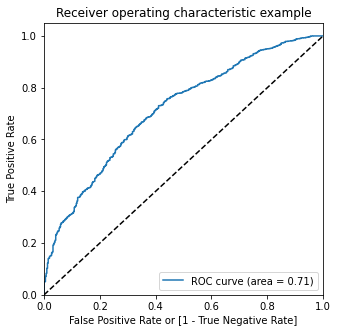

In [262]:
draw_roc(y_train_pred_final.target, y_train_pred_final.target_Prob)

### Run model on test data

In [263]:
X_test_sm = sm.add_constant(X_test)
y_test_pred = res.predict(X_test_sm)

In [264]:
y_pred_1 = pd.DataFrame(y_test_pred)
y_test_df = pd.DataFrame(y_test)
y_test_df['ID'] = y_test_df.index
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)
y_pred_final.head()

,target,ID,0
0,1,18118,0.991712
1,1,28110,0.986033
2,1,15633,0.929485
3,1,20149,0.958794
4,1,2372,0.985343


In [265]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Predicted_prob'})
# Rearranging the columns
y_pred_final = y_pred_final.reindex(['ID','target','Predicted_prob'], axis=1)
y_pred_final.head()

,ID,target,Predicted_prob
0,18118,1,0.991712
1,28110,1,0.986033
2,15633,1,0.929485
3,20149,1,0.958794
4,2372,1,0.985343


In [266]:
y_pred_final['final_predicted'] = y_pred_final.Predicted_prob.map(lambda x: 1 if x > 0.8 else 0)

In [267]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.target, y_pred_final.final_predicted)

0.9804226227470478

In [268]:
confusionMatrix = metrics.confusion_matrix(y_pred_final.target, y_pred_final.final_predicted )
confusionMatrix

array([[   2,  189],
       [   0, 9463]])

In [269]:
TP = confusionMatrix[1,1] # true positive 
TN = confusionMatrix[0,0] # true negatives
FP = confusionMatrix[0,1] # false positives
FN = confusionMatrix[1,0] # false negatives

In [270]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

1.0

In [271]:
# Let us calculate specificity
TN / float(TN+FP)

0.010471204188481676

## Decision Tree

In [272]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [273]:
cust_data_train = cust_data[['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
        'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'CUST_FOR_MONTHS', 'EMP_YEARS', 'AGE', 'target']]

In [274]:
cust_data_train = creatingDummyVariables(cust_data_train, ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
                            'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE'])

In [275]:
x = cust_data_train.drop('target',1)
y = cust_data_train['target']

In [276]:
# Split the data into training and testing data
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3)

In [277]:
# Create a Decision Tree
dt_basic = DecisionTreeClassifier(max_depth=10)

In [278]:
# Fit the training data
dt_basic.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [279]:
# Predict based on test data
y_preds = dt_basic.predict(x_test)

In [280]:
# Calculate Accuracy
accuracy_value = metrics.accuracy_score(y_test,y_preds)
accuracy_value

0.9787652786409778

In [281]:
# Create and print confusion matrix
confusion_matrix(y_test,y_preds)

array([[   4,  164],
       [  41, 9445]])

In [282]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.09      0.02      0.04       168
           1       0.98      1.00      0.99      9486

    accuracy                           0.98      9654
   macro avg       0.54      0.51      0.51      9654
weighted avg       0.97      0.98      0.97      9654



In [283]:
# Calculate the number of nodes in the tree
dt_basic.tree_.node_count

367

### Hyperparameter tuning for Decision Trees

In [284]:
# Create a Parameter grid
param_grid = {
    'max_depth' : range(5,20,5),
    'min_samples_leaf' : range(50,210,50),
    'min_samples_split' : range(50,210,50),
    'criterion' : ['gini','entropy'] 
}

In [285]:
n_folds = 5

In [286]:
dtree = DecisionTreeClassifier()
grid = GridSearchCV(dtree, param_grid, cv = n_folds, n_jobs = -1,return_train_score=True)

In [287]:
grid.fit(x_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                     

In [288]:
cv_result = pd.DataFrame(grid.cv_results_)
cv_result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.098200,0.003437,0.003807,0.000346,gini,5,50,50,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.98091,0.98091,0.98091,0.980906,0.980906,0.980908,0.000002,1,0.980908,0.980908,0.980908,0.980909,0.980909,0.980908,5.190710e-07
1,0.100090,0.009991,0.003818,0.000301,gini,5,50,100,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.98091,0.98091,0.98091,0.980906,0.980906,0.980908,0.000002,1,0.980908,0.980908,0.980908,0.980909,0.980909,0.980908,5.190710e-07
2,0.101889,0.005455,0.003526,0.000189,gini,5,50,150,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.98091,0.98091,0.98091,0.980906,0.980906,0.980908,0.000002,1,0.980908,0.980908,0.980908,0.980909,0.980909,0.980908,5.190710e-07
3,0.097559,0.004024,0.003519,0.000249,gini,5,50,200,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.98091,0.98091,0.98091,0.980906,0.980906,0.980908,0.000002,1,0.980908,0.980908,0.980908,0.980909,0.980909,0.980908,5.190710e-07
4,0.099568,0.003567,0.004003,0.000955,gini,5,100,50,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.98091,0.98091,0.98091,0.980906,0.980906,0.980908,0.000002,1,0.980908,0.980908,0.980908,0.980909,0.980909,0.980908,5.190710e-07


In [289]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 50,
 'min_samples_split': 50}

In [290]:
grid.best_score_

0.9809084045160006

In [291]:
best_grid = grid.best_estimator_
best_grid

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [292]:
best_grid.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [293]:
best_grid.score(x_test,y_test)

0.9825978868862648

## AdaBoost Classifier

In [294]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

In [295]:
clf = AdaBoostClassifier(DecisionTreeClassifier( criterion='gini',max_depth=5, min_samples_leaf=50, min_samples_split=50), n_estimators = 50)
clf.fit(x_train, y_train)

pred = clf.predict(x_test)
print(accuracy_score(y_test, pred))
print(confusion_matrix(y_test, pred))

0.976590014501761
[[  18  150]
 [  76 9410]]


In [296]:
l_rate = np.linspace(start = 0.1, stop= 1, num = 10, endpoint= True)
scores_list = []
error = []
for l in l_rate:
    clf = AdaBoostClassifier(DecisionTreeClassifier(criterion='gini',max_depth=5, min_samples_leaf=50, min_samples_split=50), n_estimators = 50, learning_rate= l)
    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)
    scores_list.append(accuracy_score(y_test, pred))
    error.append(np.mean( pred != y_test))

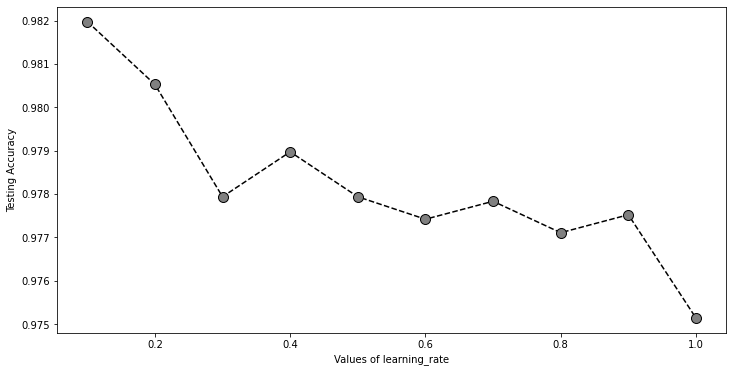

In [297]:
plt.figure(figsize=(12, 6))
plt.plot(l_rate, scores_list, color='black', linestyle='dashed', marker='o',
         markerfacecolor='grey', markersize=10)
plt.xlabel('Values of learning_rate')
plt.ylabel('Testing Accuracy')
plt.show()

In [298]:
clf = AdaBoostClassifier(DecisionTreeClassifier( criterion='gini',max_depth=5, min_samples_leaf=50, min_samples_split=50), n_estimators = 50, learning_rate=0.2)
clf.fit(x_train, y_train)

pred = clf.predict(x_test)
print(confusion_matrix(y_test, pred))   
print(accuracy_score(y_test, pred))

[[   6  162]
 [  26 9460]]
0.9805262067536772


## Concluding Thoughts

### Using AdaBoost algorithm gave us a good accuracy level.